In [88]:
# ============================================================
# Enhanced Magazine Subscription Behavior Analysis
# ============================================================
# Enhanced version with comprehensive data cleaning, EDA, and visualizations
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             confusion_matrix, classification_report, roc_curve, 
                             auc, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [90]:
# ============================================================
# PART 1: LOAD AND INITIAL EXPLORATION
# ============================================================
print("=" * 60)
print("LOADING AND EXPLORING DATA")
print("=" * 60)

df = pd.read_csv("marketing_campaign.csv")

# Initial data overview
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n" + "-" * 60)
print("First Few Rows:")
print(df.head())

print("\n" + "-" * 60)
print("Data Types:")
print(df.dtypes)

print("\n" + "-" * 60)
print("Missing Values:")
missing_info = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_info[missing_info['Missing_Count'] > 0])

print("\n" + "-" * 60)
print("Duplicate Rows:")
print(f"Number of duplicates: {df.duplicated().sum()}")

print("\n" + "-" * 60)
print("Statistical Summary:")
print(df.describe())

LOADING AND EXPLORING DATA

Dataset Shape: (2240, 29)
Rows: 2240, Columns: 29

------------------------------------------------------------
First Few Rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  20

In [92]:
# ============================================================
# PART 2: COMPREHENSIVE DATA CLEANING
# ============================================================
print("\n" + "=" * 60)
print("DATA CLEANING")
print("=" * 60)

# Store original shape
original_shape = df.shape

# Remove duplicates
df = df.drop_duplicates()
print(f"\nDuplicates removed: {original_shape[0] - df.shape[0]}")

# Handle missing values
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

# Fill numeric missing values with median
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# Fill categorical missing values with mode
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_val}")

# Detect and handle outliers using IQR method
print("\n" + "-" * 60)
print("Outlier Detection (IQR Method):")
outliers_removed = 0

for col in numeric_cols:
    if col != 'Response':  # Don't treat target as outlier
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outlier_count > 0:
            print(f"{col}: {outlier_count} outliers detected")
            # Cap outliers instead of removing
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print(f"\nFinal cleaned dataset shape: {df.shape}")



DATA CLEANING

Duplicates removed: 0
Filled Income missing values with median: 51381.5

------------------------------------------------------------
Outlier Detection (IQR Method):
Year_Birth: 3 outliers detected
Income: 8 outliers detected
MntWines: 35 outliers detected
MntFruits: 227 outliers detected
MntMeatProducts: 175 outliers detected
MntFishProducts: 223 outliers detected
MntSweetProducts: 248 outliers detected
MntGoldProds: 207 outliers detected
NumDealsPurchases: 86 outliers detected
NumWebPurchases: 4 outliers detected
NumCatalogPurchases: 23 outliers detected
NumWebVisitsMonth: 8 outliers detected
AcceptedCmp3: 163 outliers detected
AcceptedCmp4: 167 outliers detected
AcceptedCmp5: 163 outliers detected
AcceptedCmp1: 144 outliers detected
AcceptedCmp2: 30 outliers detected
Complain: 21 outliers detected

Final cleaned dataset shape: (2240, 29)



EXPLORATORY DATA ANALYSIS

Target Variable Distribution:
Response
0    1906
1     334
Name: count, dtype: int64

Class Balance: Response
0    85.09
1    14.91
Name: proportion, dtype: float64


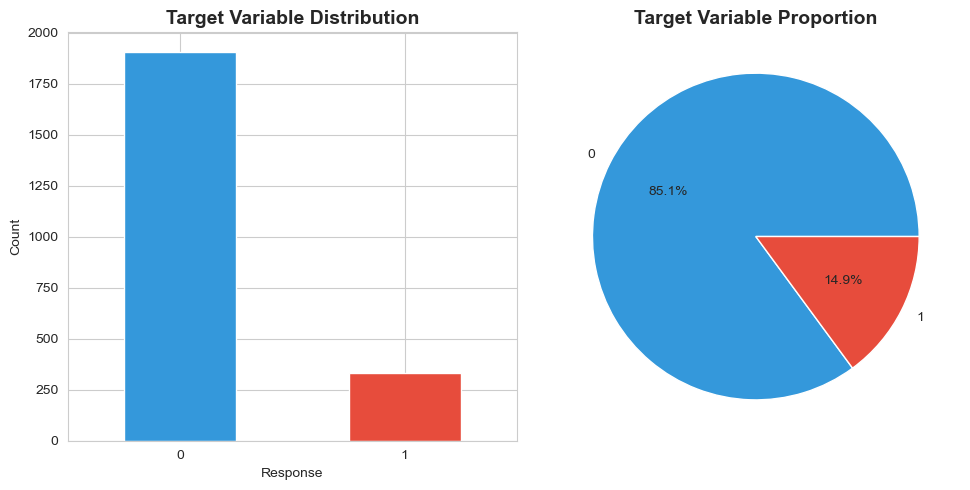

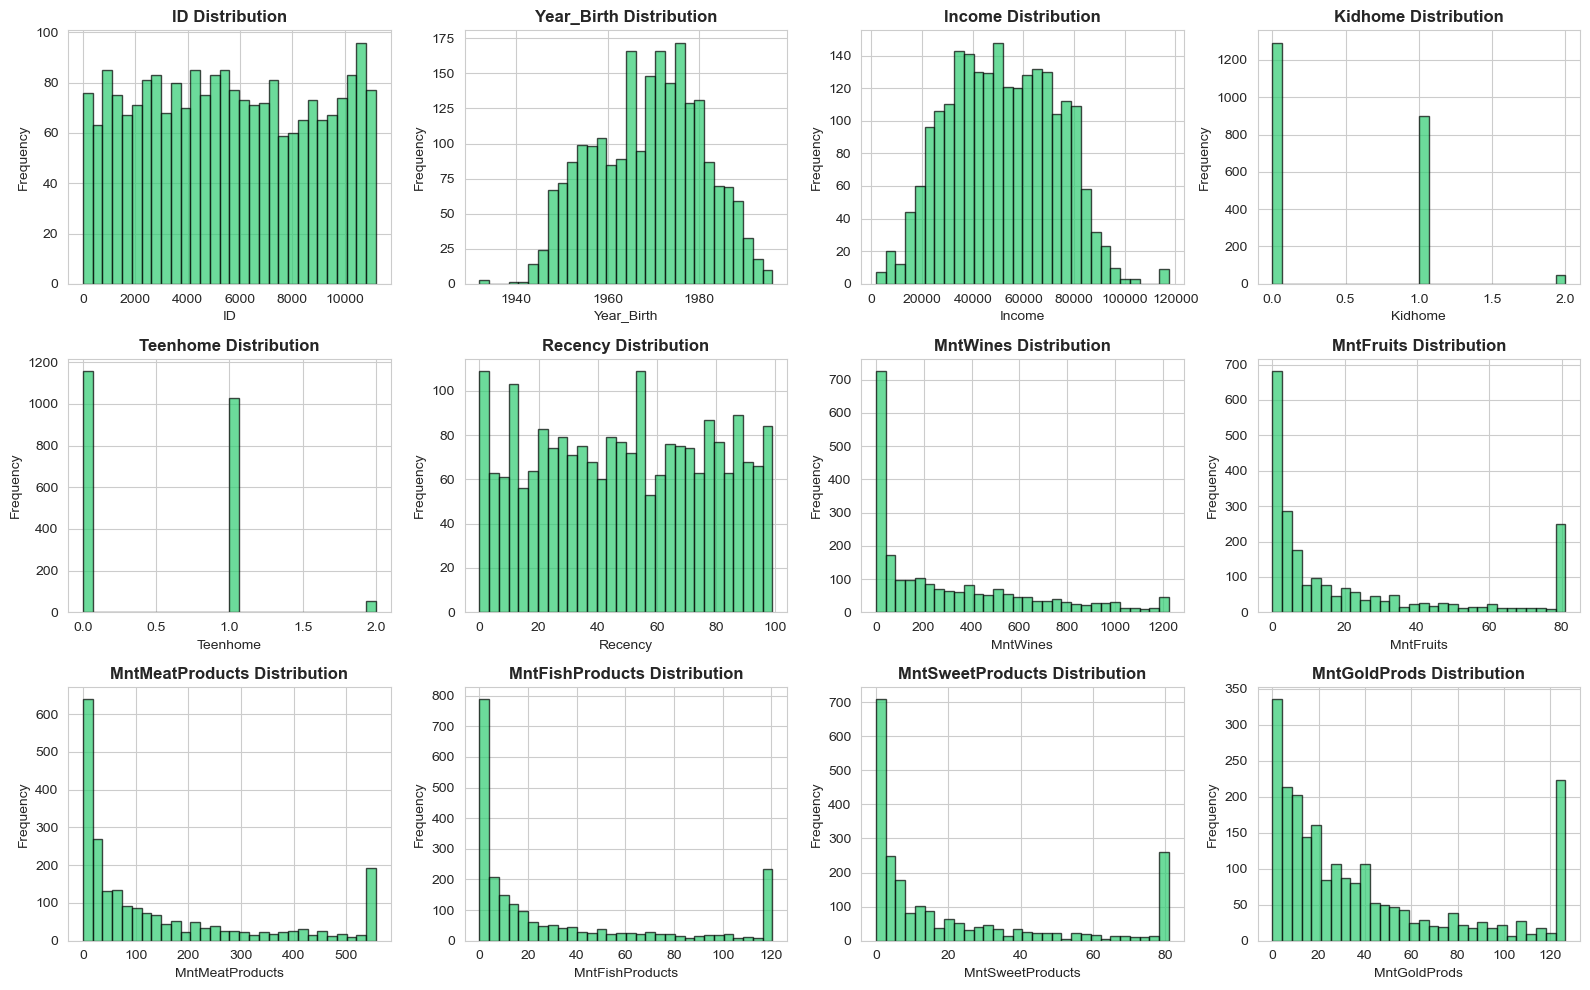

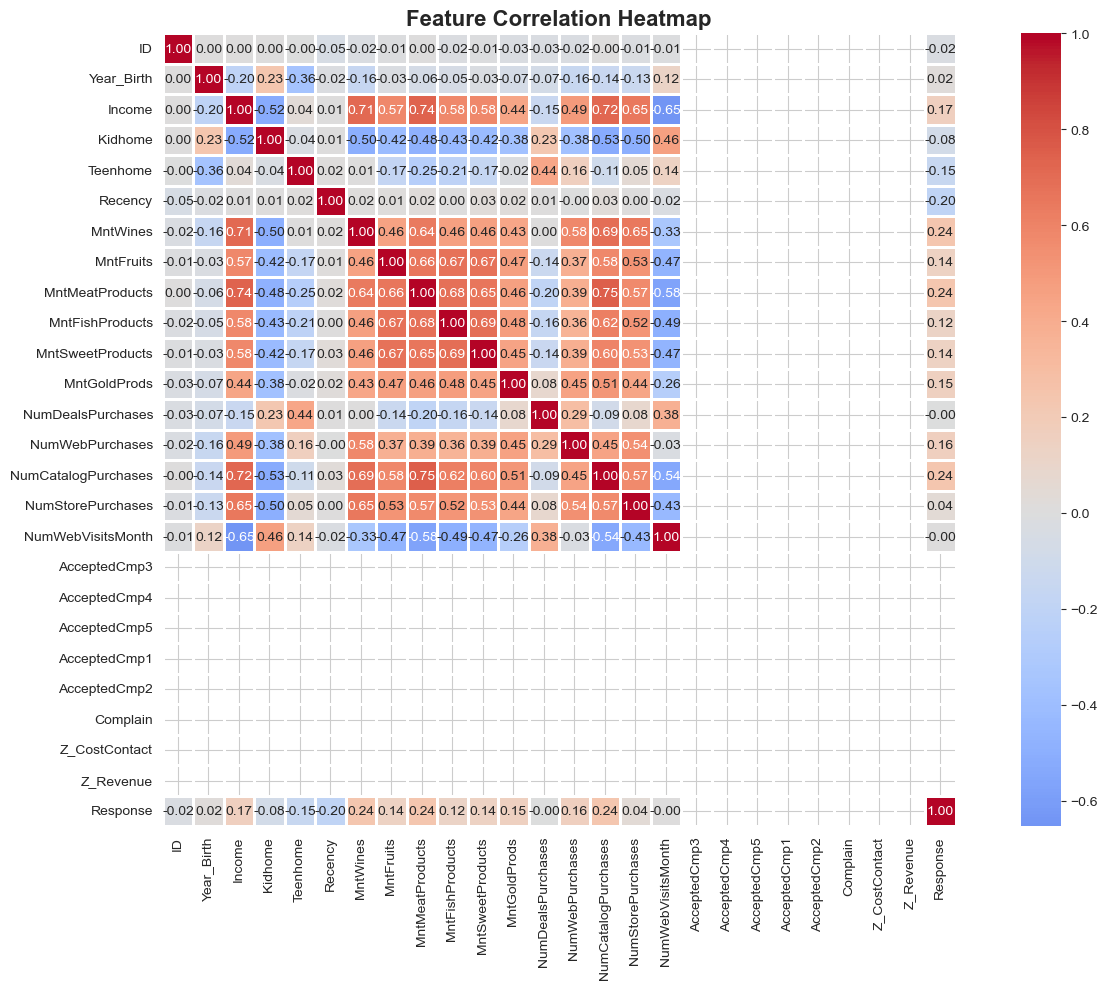

In [94]:
# ============================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================
print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Target variable distribution
if 'Response' in df.columns:
    print("\nTarget Variable Distribution:")
    print(df['Response'].value_counts())
    print(f"\nClass Balance: {(df['Response'].value_counts(normalize=True) * 100).round(2)}")
    
    # Visualization 1: Target Distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    df['Response'].value_counts().plot(kind='bar', color=['#3498db', '#e74c3c'])
    plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Response')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    df['Response'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                       colors=['#3498db', '#e74c3c'])
    plt.title('Target Variable Proportion', fontsize=14, fontweight='bold')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualization 2: Numeric Features Distribution
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_features) > 1:
    num_plots = min(len(numeric_features), 12)
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_features[:num_plots]):
        axes[i].hist(df[col], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col} Distribution', fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.savefig('numeric_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualization 3: Correlation Heatmap
numeric_df = df.select_dtypes(include=['int64', 'float64'])
if numeric_df.shape[1] > 1:
    plt.figure(figsize=(14, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


In [96]:
# ============================================================
# PART 4: DATA PREPARATION FOR MODELING
# ============================================================
print("\n" + "=" * 60)
print("DATA PREPARATION")
print("=" * 60)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)
print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Features created: {df_encoded.shape[1] - 1}")

# Feature/Target split
X = df_encoded.drop("Response", axis=1)
y = df_encoded["Response"]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed")



DATA PREPARATION

Shape after encoding: (2240, 699)
Features created: 698

Feature matrix shape: (2240, 698)
Target vector shape: (2240,)

Training set size: 1568
Test set size: 672

Feature scaling completed


In [98]:
# ============================================================
# PART 5: MODEL TRAINING AND EVALUATION
# ============================================================
print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# Logistic Regression
print("\nTraining Logistic Regression...")
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
log_predictions = log_model.predict(X_test_scaled)
log_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# SVM
print("Training Support Vector Machine...")
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]




MODEL TRAINING

Training Logistic Regression...
Training Support Vector Machine...


In [100]:
# ============================================================
# PART 6: PERFORMANCE METRICS
# ============================================================
print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)

# Calculate metrics
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, log_predictions),
        accuracy_score(y_test, svm_predictions)
    ],
    "Precision": [
        precision_score(y_test, log_predictions),
        precision_score(y_test, svm_predictions)
    ],
    "Recall": [
        recall_score(y_test, log_predictions),
        recall_score(y_test, svm_predictions)
    ],
    "F1-Score": [
        f1_score(y_test, log_predictions),
        f1_score(y_test, svm_predictions)
    ]
})

print("\n" + results.to_string(index=False))

# Detailed classification reports
print("\n" + "-" * 60)
print("LOGISTIC REGRESSION - Classification Report:")
print(classification_report(y_test, log_predictions))

print("\n" + "-" * 60)
print("SVM - Classification Report:")
print(classification_report(y_test, svm_predictions))


MODEL PERFORMANCE

              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression  0.824405   0.384615    0.30  0.337079
                SVM  0.821429   0.166667    0.05  0.076923

------------------------------------------------------------
LOGISTIC REGRESSION - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       572
           1       0.38      0.30      0.34       100

    accuracy                           0.82       672
   macro avg       0.63      0.61      0.62       672
weighted avg       0.81      0.82      0.82       672


------------------------------------------------------------
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       572
           1       0.17      0.05      0.08       100

    accuracy                           0.82       672
   macro avg       0.51      0.50      0.49       672
weight


GENERATING VISUALIZATIONS


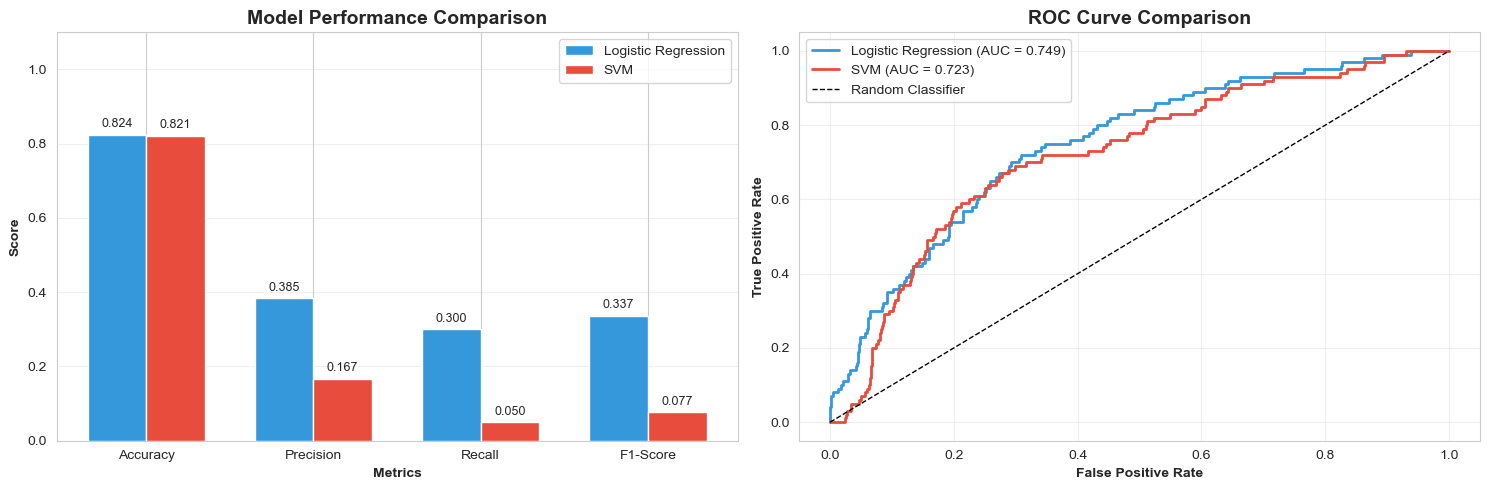

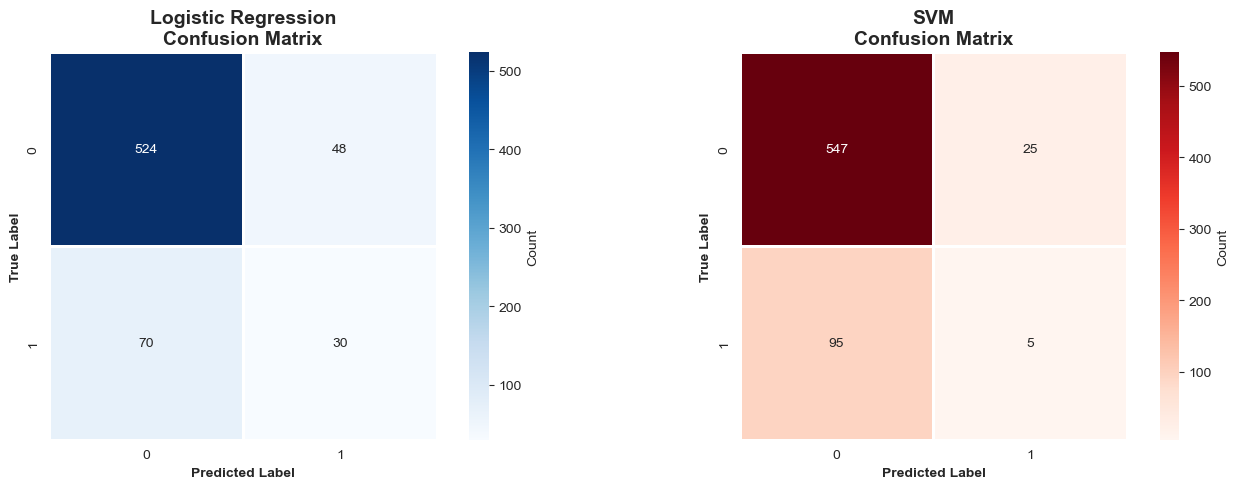

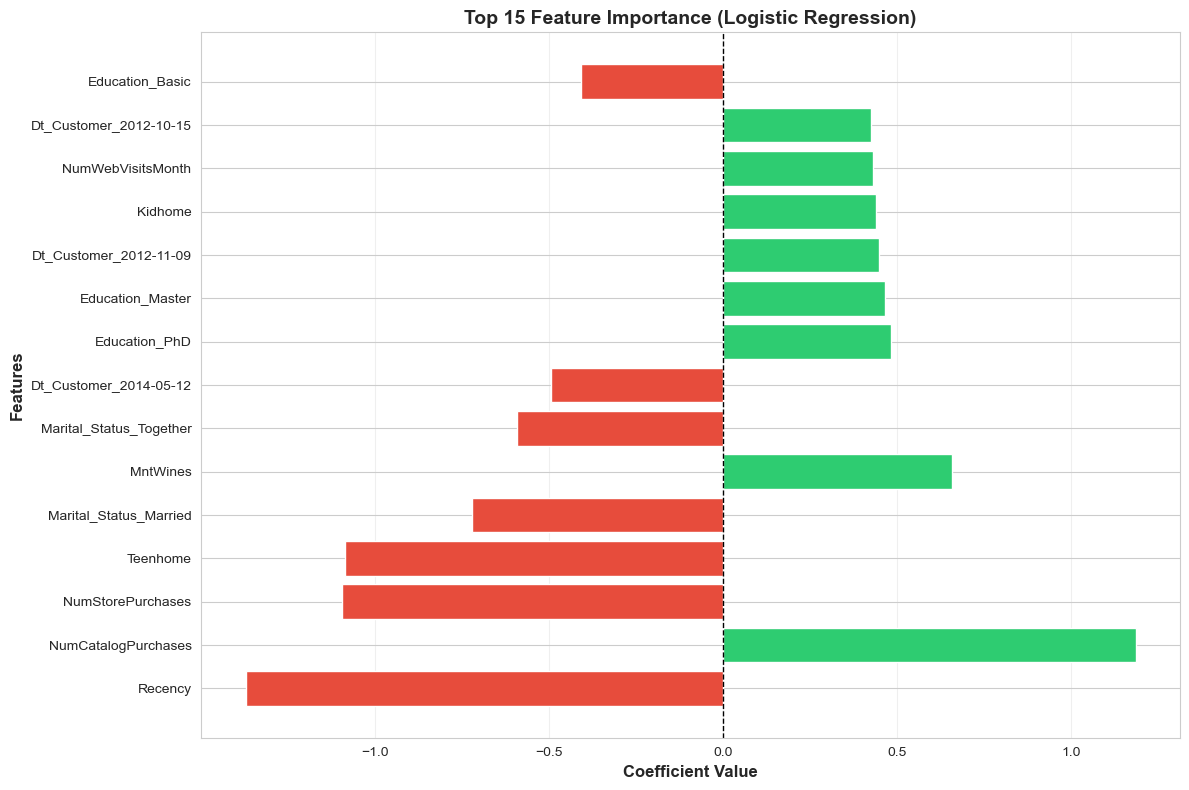

In [102]:
# ============================================================
# PART 7: VISUALIZATIONS
# ============================================================
print("\n" + "=" * 60)
print("GENERATING VISUALIZATIONS")
print("=" * 60)

# Visualization 4: Model Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, results.iloc[0, 1:], width, label='Logistic Regression', color='#3498db')
axes[0].bar(x + width/2, results.iloc[1, 1:], width, label='SVM', color='#e74c3c')
axes[0].set_xlabel('Metrics', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, metric in enumerate(metrics):
    axes[0].text(i - width/2, results.iloc[0, i+1] + 0.02, 
                f'{results.iloc[0, i+1]:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, results.iloc[1, i+1] + 0.02, 
                f'{results.iloc[1, i+1]:.3f}', ha='center', fontsize=9)

# ROC Curve
log_fpr, log_tpr, _ = roc_curve(y_test, log_proba)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba)
log_auc = auc(log_fpr, log_tpr)
svm_auc = auc(svm_fpr, svm_tpr)

axes[1].plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.3f})', 
            color='#3498db', linewidth=2)
axes[1].plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.3f})', 
            color='#e74c3c', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontweight='bold')
axes[1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 5: Enhanced Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

log_cm = confusion_matrix(y_test, log_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

# Logistic Regression confusion matrix
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'}, square=True, linewidths=2)
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')

# SVM confusion matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1], 
            cbar_kws={'label': 'Count'}, square=True, linewidths=2)
axes[1].set_title('SVM\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')
axes[1].set_ylabel('True Label', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 6: Feature Importance (Logistic Regression)
if hasattr(log_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': log_model.coef_[0]
    })
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(15)
    
    plt.figure(figsize=(12, 8))
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient Value', fontweight='bold', fontsize=12)
    plt.ylabel('Features', fontweight='bold', fontsize=12)
    plt.title('Top 15 Feature Importance (Logistic Regression)', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()



In [104]:
# ============================================================
# PART 8: SUMMARY AND RECOMMENDATIONS
# ============================================================
print("\n" + "=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n✓ Dataset processed: {df.shape[0]} records, {df.shape[1]} features")
print(f"✓ Models trained and evaluated")
print(f"✓ Visualizations generated and saved")

best_model = results.loc[results['Accuracy'].idxmax(), 'Model']
best_accuracy = results['Accuracy'].max()

print(f"\n🏆 Best performing model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f}")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)


ANALYSIS SUMMARY

✓ Dataset processed: 2240 records, 29 features
✓ Models trained and evaluated
✓ Visualizations generated and saved

🏆 Best performing model: Logistic Regression
   Accuracy: 0.8244

ANALYSIS COMPLETE
